# Experiment

Dataset: Shanghai Telecom dataset discretize on 50 clusters and 30 minute inverval. No filter

## Requirements

- Pre-processed dataset located at `{ROOT}/data/sh30-c50`
- Pre-trained model state located at `{ROOT}/src/ml/checkpoints/sh30-c100_best.pt`
- Pre-computed 100 clusters located at `{ROOT}/data/exploratory_analysis/mog_100.npy`

## Import and constants

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from src.path import ROOT

# trajectory length
SEQ_LENGTH: int = 48

# cuda flag
USE_CUDA: bool = True

if USE_CUDA and not torch.cuda.is_available():
    USE_CUDA = False
    print('fallback to cpu as CUDA is not available on this device')

## define dataset

### define path

Change the path variable here if you place your dataset files in a different location.

In [2]:
cluster_path = f'{ROOT}/exploratory_analysis/mog_50.npy'
dataset_path = str(ROOT.joinpath('data/sh30-c50'))

### split dataset

Split to pre-defined training set and test set

In [3]:
import os
from datetime import date

from src.data_preprocess.trajectory import from_dataframe
from src.ml.dataset import get_shanghai_date

file_list = os.listdir(dataset_path)

def is_test(fname: str):
    '''
    returns True if file belongs to test set
    '''
    fdate = get_shanghai_date(fname)
    ref_date = date(2014, 6, 18)
    return fdate >= ref_date and (fdate - ref_date).days < 15


test_files = [fname for fname in file_list if is_test(fname)]
train_files = [fname for fname in file_list if not is_test(fname)]

### read basestations

In [4]:
all_candidates: np.ndarray = np.load(cluster_path)

### load dataset

Load dataset files into in-memory.

In [35]:
from src.data_preprocess.trajectory import from_dataframe, Trajectory

def read_csv(fname: str):
    # https://stackoverflow.com/questions/36909368/precision-lost-while-using-read-csv-in-pandas#:~:text=Pandas%20uses%20a%20dedicated%20decimal-to-binary%20converter%20that%20sacrifices,of%20speed.%20Passing%20float_precision%3D%27round_trip%27%20to%20read_csv%20fixes%20this.
    df = pd.read_csv(f'{dataset_path}/{fname}', float_precision='round_trip')
    return from_dataframe(df, SEQ_LENGTH)

test_trajectories: list[dict[str, Trajectory]] = [None] * len(test_files)

for i in tqdm.trange(len(test_files)):
    fname = test_files[i]
    test_trajectories[i] = read_csv(fname)

100%|██████████| 15/15 [00:49<00:00,  3.28s/it]


Optional: remove stationary users

In [36]:
min_unique_loc_count = 3

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if len(set(trajectory.points)) >= min_unique_loc_count
    }

Optional: remove non-persistent users

In [37]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

27

## baseline

#### define metric

In [7]:
from src.main.baseline import RecoveryFromAshDistance

ref_lat = np.median(all_candidates[:, 0]).item()
ref_long = np.median(all_candidates[:, 1]).item()

day_timestamp = 12

distance_metric = RecoveryFromAshDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

#### night time trajectory recovery

In [38]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery:   0%|          | 0/15 [00:00<?, ?it/s]

night time recovery: 100%|██████████| 15/15 [00:00<00:00, 328.23it/s]


Evaluate

In [39]:
from src.eval.metrics import greedy_match, similarity, mean_distance

avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:00<00:00, 327.46it/s]

average accuracy: 0.9263374485596707
average recovery error: 1.1937357507980815


#### single day trajectory recovery (night time + day time)

In [40]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:00<00:00, 98.30it/s]


Evaluate

In [41]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:00<00:00, 499.91it/s]

average accuracy: 0.3845164609053499
average recovery error: 11.990997896121037


### cross-day trajectory recovery

In [42]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

persistent_trajectories: list[dict[str, Trajectory]] = [None] * len(test_trajectories)

for i in range(len(test_trajectories)):
    persistent_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

27

single day trajectory recovery

In [43]:
predicted: list[list[Trajectory]] = [None] * len(persistent_trajectories)

for i in tqdm.trange(0, len(persistent_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in persistent_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:00<00:00, 104.31it/s]


cross-day recovery

In [44]:
from src.main.baseline import DenseCrossDayTrajectoryRecovery
from src.ml.dataset import create_point_to_class_map

point_to_index = create_point_to_class_map(all_candidates)

algorithm = DenseCrossDayTrajectoryRecovery(predicted, point_to_index, chunk_size=100)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery:   0%|          | 0/14 [00:00<?, ?it/s]c:\users\chinp\source\capstone-project-9900w16aaiadvance\src\main\baseline.py:319: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(np.log(counts) * counts, axis=-1)
c:\users\chinp\source\capstone-project-9900w16aaiadvance\src\main\baseline.py:319: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(np.log(counts) * counts, axis=-1)
cross-day recovery: 100%|██████████| 14/14 [00:00<00:00, 464.00it/s]


Evaluate

average accuracy: 0.23209876543209876
average recovery error: 15.14175774447672


Text(0.5, 0, 'recovery error (km)')

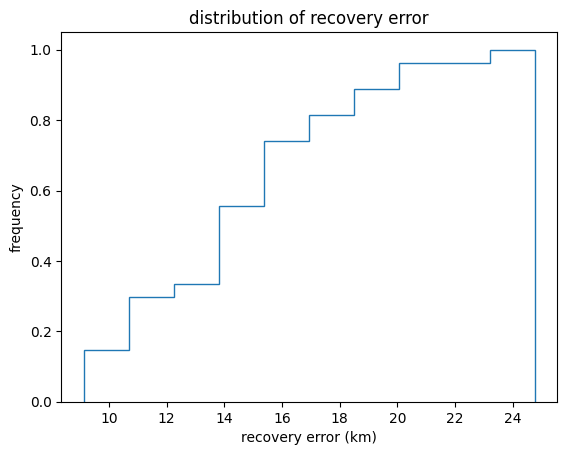

In [45]:
import copy
from src.eval.metrics import similarity, mean_distance

# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

[0.0, 0.25925925925925924, 1.0, 1.0, 1.0]


Text(0, 0.5, 'unique percentage')

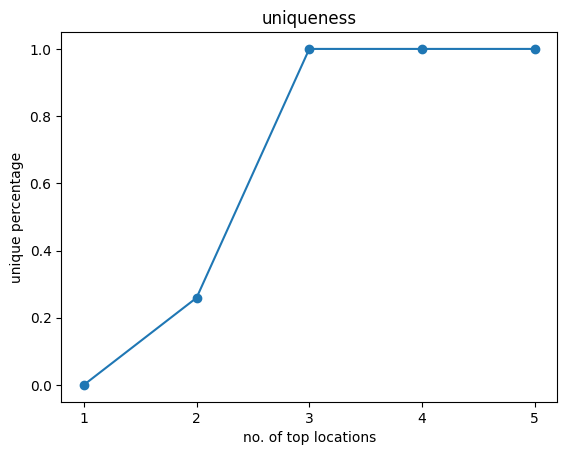

In [46]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted_trajectories, i) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o')
plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')

### Result

all persistent users (~1.3k users in total):

| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 98 | 0.47 |
| 2 | 75 | 4.8 | 
| 3 | 65 | 6.6 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.00076 |
| 3 | 0.22 |
| 4 | 0.41 |
| 5 | 0.48 |

persistent users with >= 3 unique locations per day (38 users in total)
| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 93 | 1.2 |
| 2 | 38 | 12.0 | 
| 3 | 23 | 15.1 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.26 |
| 3 | 1.0 |
| 4 | 1.0 |
| 5 | 1.0 |

## deep learning

### load trained model

load model trained by self-supervision.

In [19]:
from src.ml.model import TrajectoryModel
from src.ml.model.modules import TransformerTrajectoryEncoder, BaseStationEmbedding
from src.ml.checkpoint import DEFAULT_CHECKPOINT_DIR

model_dim = 128

base_station_embedding = BaseStationEmbedding(
    feat_dim=(2, 64),
    context_dim=(31, 48),
    out_dim=model_dim,
    layer_norm=True
)

trajectory_encoder = TransformerTrajectoryEncoder(
    in_dim=model_dim,
    max_len=SEQ_LENGTH,
    hid_dim=(model_dim, model_dim * 2, 8),
    do_prob=0.2,
    n_blocks=4,
)

model = TrajectoryModel(
    base_station_embedding=base_station_embedding,
    trajectory_encoder=trajectory_encoder,
)

model.load_state_dict(torch.load(f'{DEFAULT_CHECKPOINT_DIR}/sh30-c100_best.pt')['model'])
model.eval()

if USE_CUDA:
    model.cuda()
    torch_device = torch.device('cuda', 0)
else:
    torch_device = torch.device('cpu')

### Define pre-process pipeline

In [21]:
from src.ml.utils import create_shanghai_preprocessor, to_cartesian

all_candidates_100 = torch.tensor(np.load(f'{ROOT}/exploratory_analysis/mog_100.npy'), dtype=torch.float32)
ref_lat = all_candidates_100[:, 0].median()
ref_long = all_candidates_100[:, 1].median()

all_candidates_cart = to_cartesian(all_candidates_100, ref_point=(ref_lat, ref_long))
min_x, max_x = all_candidates_cart[:, 0].min().item(), all_candidates_cart[:, 0].max().item()
min_y, max_y = all_candidates_cart[:, 1].min().item(), all_candidates_cart[:, 1].max().item()
del all_candidates_cart
del all_candidates_100

preprocess = create_shanghai_preprocessor(
    x_range=(min_x, max_x),
    y_range=(min_y, max_y),
    ref_point=(ref_lat, ref_long)
)

### night time recovery

In [47]:
from src.ml.dataset import get_shanghai_date
from src.main.ml import create_trajectory_model_cost_matrix_fn

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i].values()]
    trajectory_date = get_shanghai_date(test_files[i])

    neural_metric = create_trajectory_model_cost_matrix_fn(
        model=model,
        preprocess=preprocess,
        weekday=trajectory_date.weekday(),
        trajectory_len=day_timestamp,
        device=torch_device
    )

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=neural_metric,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery: 100%|██████████| 15/15 [00:00<00:00, 29.13it/s]


Evaluate

In [48]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:00<00:00, 941.78it/s]

average accuracy: 0.9380658436213991
average recovery error: 1.1862279619721732


### single day recovery

In [49]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i].values()]
    trajectory_date = get_shanghai_date(test_files[i])

    neural_metric = create_trajectory_model_cost_matrix_fn(
        model=model,
        preprocess=preprocess,
        weekday=trajectory_date.weekday(),
        trajectory_len=SEQ_LENGTH,
        device=torch_device
    )

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=neural_metric,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


Evaluate

In [50]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:00<00:00, 538.03it/s]

average accuracy: 0.4930041152263375
average recovery error: 8.674342337887975


### Cross day trajectory recovery

In [51]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

persistent_trajectories: list[dict[str, Trajectory]] = [None] * len(test_trajectories)

for i in range(len(test_trajectories)):
    persistent_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

27

single day trajectory recovery

In [52]:
predicted: list[list[Trajectory]] = [None] * len(persistent_trajectories)

for i in tqdm.trange(0, len(persistent_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in persistent_trajectories[i].values()]
    trajectory_date = get_shanghai_date(test_files[i])

    neural_metric = create_trajectory_model_cost_matrix_fn(
        model=model,
        preprocess=preprocess,
        weekday=trajectory_date.weekday(),
        trajectory_len=SEQ_LENGTH,
        device=torch_device
    )

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=neural_metric,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:01<00:00,  8.04it/s]


cross-day recovery

In [53]:
from src.main.baseline import DenseCrossDayTrajectoryRecovery

algorithm = DenseCrossDayTrajectoryRecovery(predicted, point_to_index, chunk_size=100)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery: 100%|██████████| 14/14 [00:00<00:00, 418.85it/s]


Evaluation

average accuracy: 0.34897119341563787
average recovery error: 12.040474623539705


Text(0.5, 0, 'recovery error (km)')

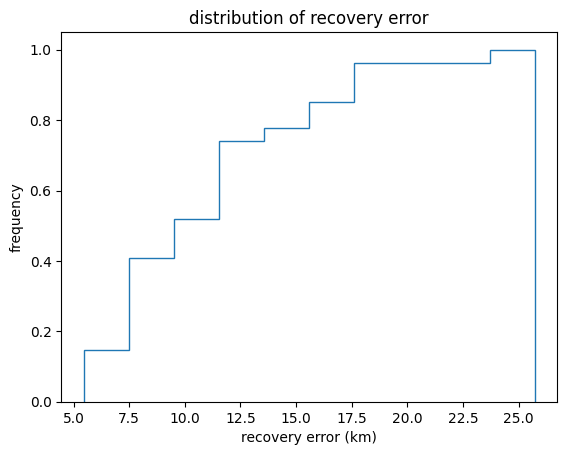

In [54]:
# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances_ml = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances_ml.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances_ml, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

plot uniqueness

[0.0, 0.5555555555555556, 0.8518518518518519, 1.0, 1.0]


Text(0, 0.5, 'unique percentage')

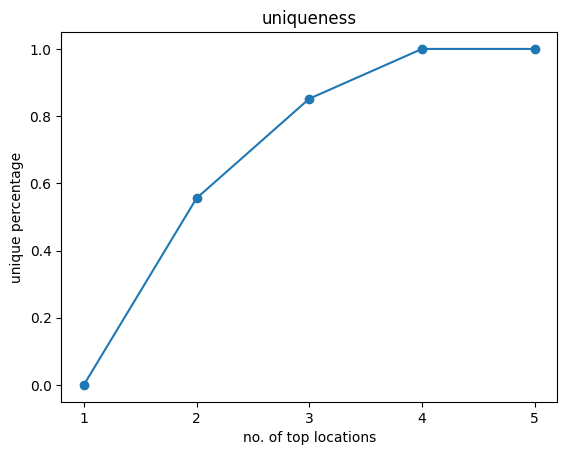

In [55]:
uniqueness = [uniqueness_list(predicted_trajectories, i) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o')
plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')

### Result

all persistent users (~1.3k users in total):

| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 98 | 0.51 |
| 2 | 78 | 3.7 | 
| 3 | 68 | 5.3 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.0 |
| 3 | 0.095 |
| 4 | 0.24 |
| 5 | 0.30 |

persistent users with >= 3 unique locations per day (38 users in total) (TODO)
| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 94 | 1.2 |
| 2 | 49 | 8.7 | 
| 3 | 35 | 12.0 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.56 |
| 3 | 0.85 |
| 4 | 1.0 |
| 5 | 1.0 |

plot accuracy

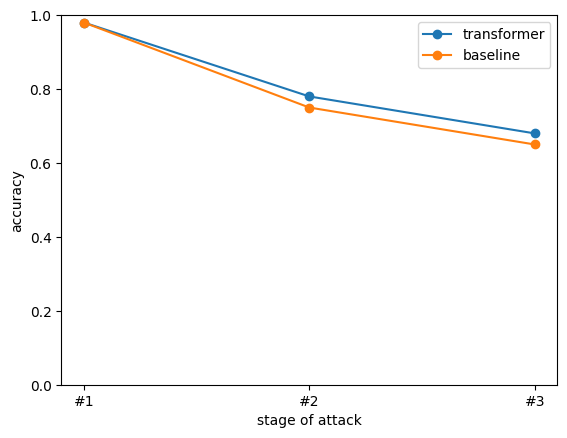

In [32]:
plt.plot(['#1', '#2', '#3'], [0.98, 0.78, 0.68], marker='o', label='transformer')
plt.plot(['#1', '#2', '#3'], [0.98, 0.75, 0.65], marker='o', label='baseline')

plt.ylabel('accuracy')
plt.xlabel('stage of attack')
plt.ylim((0, 1))
plt.legend()

plot uniqueness

Text(0, 0.5, 'uniqueness')

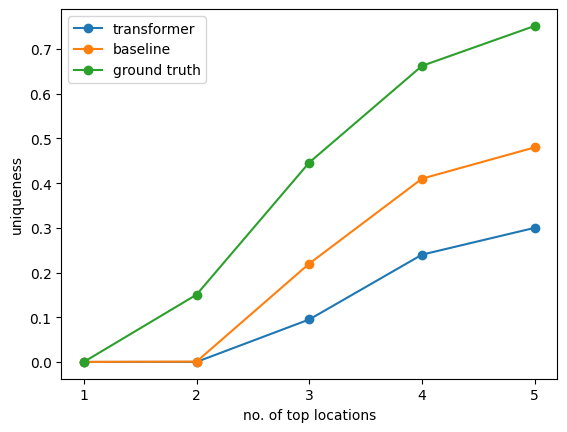

In [33]:
# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

ground_truth_uniqueness = [ uniqueness_list(target_trajectories, k + 1) for k in range(5) ]

plt.plot(['1', '2', '3', '4', '5'], [0.0, 0.0, 0.095, 0.24, 0.30], marker='o', label='transformer')
plt.plot(['1', '2', '3', '4', '5'], [0.0, 0.00076, 0.22, 0.41, 0.48], marker='o', label='baseline')
plt.plot(['1', '2', '3', '4', '5'], ground_truth_uniqueness, marker='o', label='ground truth')

plt.legend()
plt.xlabel('no. of top locations')
plt.ylabel('uniqueness')

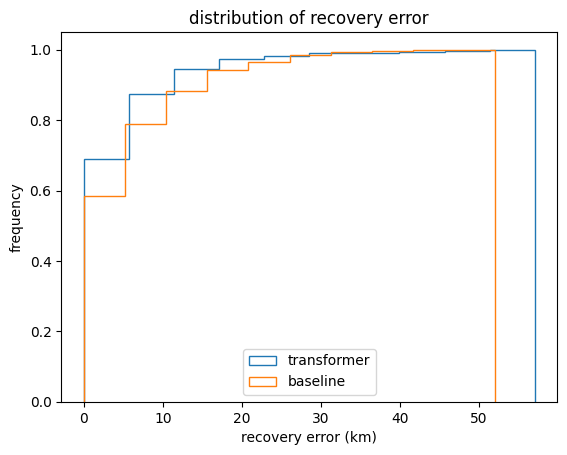

In [34]:
plt.title('distribution of recovery error')
plt.hist(distances_ml, cumulative=True, density=True, histtype='step', label='transformer')
plt.hist(distances, cumulative=True, density=True, histtype='step', label='baseline')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')
plt.legend()